In [1]:
!pip3 install torch torchvision

In [2]:
!nvidia-smi

Tue Nov 16 15:00:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import sys
print(sys.version)
device = 'cuda'

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [4]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

print('PyTorch version:', torch.__version__)

PyTorch version: 1.10.0+cu111


In [5]:
class PSwish(torch.nn.Module):
    def __init__(self,training):
        super(PSwish,self).__init__()
        self.a = torch.nn.Parameter(data=torch.zeros((1)),requires_grad=training)
        self.a.data.uniform_(0.1,0.98)
        

    def forward(self, x):
        tmp = self.a.data >= 0.99
        self.a.data[tmp] = 0.99
        tmp = self.a.data < 0.01
        self.a.data[tmp] = 0.01
        s=torch.sigmoid(x)      
        g1=x*s
        #g2=g1+self.a*s*(1-g1)
        
        #x*torch.log(1+torch.exp(-x*self.a))

        return x*0.00001 #x*torch.log(1+torch.exp(-x*self.a))#g2 

In [6]:
class SimpleCNN(nn.Module):
#imágenes salida: 10 y 50, filtros 5*5 y strick de 1
    def __init__(self, num_channels=1, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 6, 3, stride=2, padding=0)#imagen de entrada/ imagenes de salida/filtro de 3x3/ salto de pixel/borde de la imagen  3*3--5*5
        self.conv2 = nn.Conv2d(6, 32, 3, stride=1, padding=0)
        #self.relu1= PSwish(True)
        self.relu1= nn.ReLU(6)
        self.relu2= nn.ReLU(32)
        self.relu3= nn.ReLU(100)
        self.pool1 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5*5*32, 100)
        self.fc2 = nn.Linear(100, num_classes)
        
    def forward(self, X): 
        #28*28
        X = self.relu1(self.conv1(X))
        #([128, 10, 24, 24])
        X = self.relu2(self.conv2(X))
        #([128, 50, 20, 20])
        X = self.pool1(X)
        #([128, 50, 10, 10])
        X = X.reshape(-1, 5*5*32)
        #[128, 5000]
        X = self.fc1(X)
        #[128, 100]
        X = self.relu3(X)
        #[128, 100]
        X = self.fc2(X)
  
        return X  # logits  

In [7]:
# transform for the training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

# use the same transform for the validation data
valid_transform = train_transform

# load datasets, downloading if needed
train_set = MNIST('./data/mnist', train=True, download=True, 
                  transform=train_transform)
valid_set = MNIST('./data/mnist', train=False, download=True, 
                  transform=valid_transform)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



In [8]:
class AverageBase(object):
    
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None
       
    def __str__(self):
        return str(round(self.value, 4))
    
    def __repr__(self):
        return self.value
    
    def __format__(self, fmt):
        return self.value.__format__(fmt)
    
    def __float__(self):
        return self.value
    

class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """
    
    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count
        
    def update(self, value):
        self.value = (self.value * self.count + float(value))
        self.count += 1
        self.value /= self.count
        return self.value


class MovingAverage(AverageBase):
    """
    An exponentially decaying moving average (EMA).
    """
    
    def __init__(self, alpha=0.99):
        super(MovingAverage, self).__init__(None)
        self.alpha = alpha
        
    def update(self, value):
        if self.value is None:
            self.value = float(value)
        else:
            self.value = self.alpha * self.value + (1 - self.alpha) * float(value)
        return self.value

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


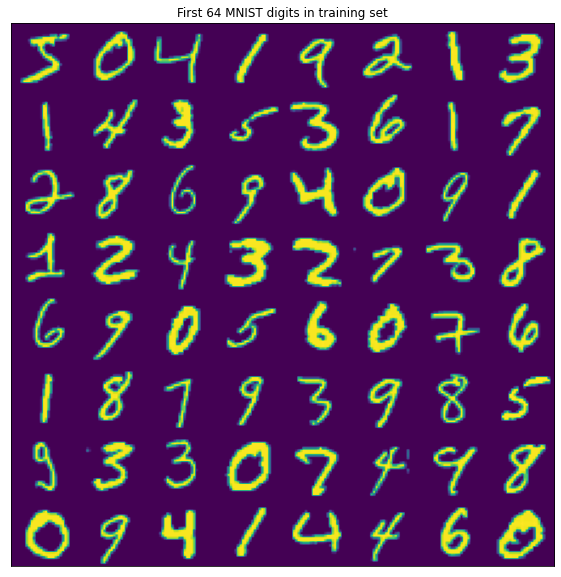

Labels: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0]


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [9]:
plt.figure(figsize=(10,10))

sample = train_set.train_data[:64]
# shape (64, 28, 28)
sample = sample.reshape(8,8,28,28)
# shape (8, 8, 28, 28)
sample = sample.permute(0,2,1,3)
# shape (8, 28, 8, 28)
sample = sample.reshape(8*28,8*28)
# shape (8*28, 8*28)
plt.imshow(sample)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('First 64 MNIST digits in training set')
plt.show()

print('Labels:', train_set.train_labels[:64].numpy())

In [10]:
from IPython.display import HTML, display

class ProgressMonitor(object):
    """
    Custom IPython progress bar for training
    """
    
    tmpl = """
        <p>Loss: {loss:0.4f}   {value} / {length}</p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
    """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

In [11]:
train_loader = DataLoader(train_set, batch_size=128, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=256, num_workers=0, shuffle=False)

In [12]:
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (relu2): ReLU(inplace=True)
  (relu3): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

In [14]:
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [15]:
!mkdir -p checkpoints

In [16]:
def train(optimizer, model, num_epochs=10, first_epoch=1):
    
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    valid_losses = []

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)

        # train phase
        model.train()

        # create a progress bar
        progress = ProgressMonitor(length=len(train_set))

        train_loss = MovingAverage()

        for batch, targets in train_loader:
            # Move the training data to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # clear previous gradient computation
            optimizer.zero_grad()

            # forward propagation
            predictions = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer.step()

            # update average loss
            train_loss.update(loss)

            # update progress bar
            progress.update(batch.shape[0], train_loss)

        print('Training loss:', train_loss)
        train_losses.append(train_loss.value)


        # validation phase
        model.eval()

        valid_loss = RunningAverage()

        # keep track of predictions
        y_pred = []

        # We don't need gradients for validation, so wrap in 
        # no_grad to save memory
        with torch.no_grad():

            for batch, targets in valid_loader:

                # Move the training batch to the GPU
                batch = batch.to(device)
                targets = targets.to(device)

                # forward propagation
                predictions = model(batch)

                # calculate the loss
                loss = criterion(predictions, targets)

                # update running loss value
                valid_loss.update(loss)

                # save predictions
                y_pred.extend(predictions.argmax(dim=1).cpu().numpy())

        print('Validation loss:', valid_loss)
        valid_losses.append(valid_loss.value)

        # Calculate validation accuracy
        y_pred = torch.tensor(y_pred, dtype=torch.int64)
        accuracy = torch.mean((y_pred == valid_set.test_labels).float())
        print('Validation accuracy: {:.4f}%'.format(float(accuracy) * 100))

        # Save a checkpoint
        checkpoint_filename = 'mnist-{:03d}.pth.tar'.format(epoch)
        print(checkpoint_filename)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        ###################
        #checkpoint = torch.load('C:/Users/jcruzvax/Downloads/mnist-001.pth.tar',map_location='cpu')
        #model = checkpoint['model']
        ##model.keys() has the layer names
        #relu1_a = np.asarray(model['relu1.a'].data)[0,...]
        ###################
    
    return train_losses, valid_losses, y_pred

In [17]:
train_losses, valid_losses, y_pred = train(optimizer, model, num_epochs=1)

Epoch 1


Training loss: 0.1708
Validation loss: 0.0911
Validation accuracy: 97.1500%
mnist-001.pth.tar


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [18]:
g=torch.Tensor([-1.3]).type(torch.cuda.FloatTensor)
1/torch.exp(torch.lgamma(g))

tensor([0.3004], device='cuda:0')

In [19]:
def myGamma2(x):
  d = -2*((x < 0)&((abs(x)%2)<1)) + 1
  return d*torch.exp(-torch.lgamma(x))
  

In [20]:
g=torch.Tensor([-1]).type(torch.cuda.FloatTensor)
myGamma2(g)

tensor([0.], device='cuda:0')